# Archive - Converting between mole components and basis species molalities

## This reflects the old version using element components

Equilibrate specifies compositions in terms of mole proportions of components, but EQ3 requires the composition of the system to be set in terms of molalities. A molality is the moles of a component per kg of pure H$_2$O in the fluid. Importantly, the 1 kg does not include any H$_2$O molecules in complexes. While the moles of H$_2$O in the fluid will always be constant, the presence of H$_2$O in the complexes and the presence of H$^+$, OH$^-$, and O$_2$ species mean conserving mass becomes not straightforward...

To some extent we cannot get around EQ3 wanting to behave as an open system, we cannot specify both the H and O contents of the bulk fluid abitrarily. Even if the composition we give EQ3 is charge balanced, the value of fO2 will imply a particular O$_{2(aq)}$ content in the fluid. The only (or at least easiest) way I see around this is to run EQ3 calculations at specified fO2 and not mass balancing on O. Therefore mass balance has to be maintained for H (and the other components).

For a simple system (H, O, Na), we can specify the system bulk composition in terms of the mole fractions:

$$ n_H, n_{Na} $$

Let's assume the only species that can form are: H$_2$O, H$^+$, OH$^-$, O$_{2(aq)}$, and Na$^+$. Then mass balance on H is achieved by:

$$ k n_H = 2 m_{H2O} + m_{H+} + m_{OH-} $$

where $m$ donotes molality. The parameter $k$ is a constant for converting between the mass of the system implied by the moles of components and the mass of the system dictated by having 1 kg of pure H$_2$O in the fluid.

Since the molalities of each complex are determined by solving the set of simultaneous equations defined by their equilibrium constants (i.e., the EQ3 calculation) and are not possible to determine without numerical solution, we have to iterate to find the correct value of $k$ for the system. This constant will then determine the molalities of the other elements:

$$ m_{Na} = k n_{Na} $$

In this notebook I demonstrate this calculation...

In [67]:
import pyDEW
import numpy as np
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from copy import copy

Set up a small demo system:

In [2]:
elements = ['O', 'H', 'Na']
basis_species = ['H2O', 'H+', 'NA+', 'O2(G)']
other_species = ['OH-', 'O2(AQ)']

In [3]:
system = pyDEW.System(basis_species=basis_species,
                     other_species=other_species,
                     elements=elements,
                     minerals=[],
                     gases=[],
                     hydrated_species={},
                     solid_solutions={})

/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._phase_info = self._phase_info.append(phs_info, ignore_index=True)
/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._phase_info = self._phase_info.append(phs_info, ignore_index=True)
/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._phase_info = self._phase_info.append(phs_info, ignore_index=True)
/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecate

Define a bulk composition in terms of mole components (ignoring fO2 as a default value will be used when running pyDEW):

In [4]:
n_H = 0.95
n_Na = 0.05

Estimate a starting value of $k$:

In [5]:
m_H2O = 55.5086815578

k = 2 * m_H2O / n_H
k

116.86038222694738

This implies a Na molality:

In [6]:
m_Na = k * n_Na
m_Na

5.8430191113473695

Build a fluid with these initial guesses:

In [7]:
molalities = {'NA+': m_Na}
T = 700.0 + 273.15
P = 10000.0

fluid = pyDEW.Fluid(system, T, P, molalities=molalities)

We can calculate a misfit from mass balance:

In [8]:
misfit_H = k * n_H - fluid.elemental_comp_molality['H']
misfit_H

-5.843019084399998

In [9]:
misfit_NA = k * n_H - fluid.elemental_comp_molality['NA']
misfit_NA

105.17434411560001

Now we can calculate a new value for $k$:

In [10]:
k = fluid.elemental_comp_molality['H'] / n_H
k

123.01092863157896

## Create an iteration

In [11]:
def mass_balance_iteration(system, T, P, n_H, n_Na, fluid=None):
    
    # The molality of H2O:
    m_H2O = 55.5086815578
    
    # If initialising a new calculation, set molalities of OH-, H+, etc to 0:
    if fluid is None:
        k = 2 * m_H2O / n_H
    else:
        k = fluid.elemental_comp_molality['H'] / n_H
    
    m_Na = k * n_Na
    
    molalities = {'NA+': m_Na}
    fluid = pyDEW.Fluid(system, T, P, molalities=molalities)
    
    misfit_H = k * n_H - fluid.elemental_comp_molality['H']
    
    misfit_Na = k * n_Na - fluid.elemental_comp_molality['NA']

    
    return fluid, k, misfit_H, misfit_Na

In [21]:
T = 700.0 + 273.15
P = 10000.0
n_H = 0.95
n_Na = 0.05

iter_k = []
iter_misfit_Na = []
iter_misfit_H = []

iter_number = 10

fluid = None

for i in range(iter_number):
    fluid, k, misfit_H, misfit_Na = mass_balance_iteration(system, T, P, n_H, n_Na, fluid)
    iter_k.append(k)
    iter_misfit_Na.append(misfit_Na)
    iter_misfit_H.append(misfit_H)

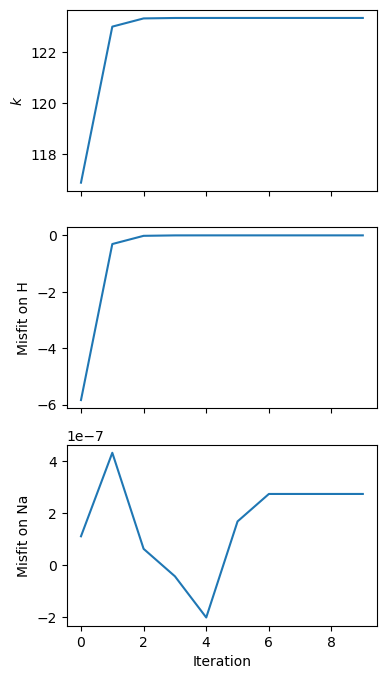

In [22]:
f, a = plt.subplots(3, 1, figsize=(4, 8), sharex='col')

a[0].plot(range(iter_number), iter_k)
a[1].plot(range(iter_number), iter_misfit_H)
a[2].plot(range(iter_number), iter_misfit_Na)

a[2].set_xlabel('Iteration')
a[0].set_ylabel('$k$')
a[1].set_ylabel('Misfit on H')
a[2].set_ylabel('Misfit on Na')

plt.show()

In [23]:
iter_misfit_Na

[1.1134736954687696e-07,
 4.315789485787036e-07,
 6.315789491395662e-08,
 -4.2105261499614244e-08,
 -1.9999999967268423e-07,
 1.6842105310388433e-07,
 2.7368421129381204e-07,
 2.7368421129381204e-07,
 2.7368421129381204e-07,
 2.7368421129381204e-07]

The remaining misfit on Na is due to rounding on the input file. At the moment 6 S.F. after the decimal point are all that EQ3 permits. It might be possible to alter the fortran code if this proves too restrictive.

## Compare iteration with root finding algorithm
It might be faster to use a root finding algorithm, especially if the misfit is close to linear.

In [25]:
def misfit_H_rootfinder(k, system, T, P, n_H, n_Na):
                        
    m_Na = k * n_Na
    
    molalities = {'NA+': m_Na}
    fluid = pyDEW.Fluid(system, T, P, molalities=molalities)
    
    misfit_H = k * n_H - fluid.elemental_comp_molality['H']
    
    return misfit_H

In [28]:
T = 700.0 + 273.15
P = 10000.0
n_H = 0.95
n_Na = 0.05

m_H2O = 55.5086815578

soln = root_scalar(misfit_H_rootfinder,
                   x0 = 2 * m_H2O / n_H,
                   x1 = 2 * m_H2O / n_H + 10,
                   args = (system, T, P, n_H, n_Na)
                   )
soln

      converged: True
           flag: 'converged'
 function_calls: 4
     iterations: 3
           root: 123.3526254736842

For this simple example, at least, the root finding algorithm is more efficient. It needed only 4 function calls to find the solution, as opposed to 7 by direct iteration.

Check that the correct value has been found:

In [34]:
k = soln.root
m_Na = k * n_Na
    
molalities = {'NA+': m_Na}
fluid = pyDEW.Fluid(system, T, P, molalities=molalities)

misfit_H = k * n_H - fluid.elemental_comp_molality['H']
print(f"Misfit H:  {misfit_H:.3}")

misfit_Na = k * n_Na - fluid.elemental_comp_molality['NA']
print(f"Misfit Na:  {misfit_Na:.3}")

Misfit H:  -2.84e-14
Misfit Na:  2.74e-07


The iteration found a value of 0 for the H misfit, but I suspect this is just as good. Changing the settings on the root finder would probably give a better precision is necessary.

## Scale to more complex fluids
Here I generate a preliminary version of the routine that will be added to the pyDEW module.

I will still stick with a relatively simple system, but the code is intended to be agnostic of what this system is:

In [44]:
elements = ['O', 'H', 'Si', 'Na', 'Cl', 'K']
basis_species = ['H2O', 'H+', 'H4SIO4(AQ)', 'NA+', 'CL-', 'K+', 'O2(G)']
other_species = ['H6SI2O7(AQ)', 'H8SI3O10(AQ)', 'H3SIO4-', 'OH-', 'O2(AQ)', 'NACL(AQ)']
hydrated_species = pyDEW.defaultsystem.hydrated_species

In [45]:
system = pyDEW.System(basis_species=basis_species,
                     other_species=other_species,
                     elements=elements,
                     minerals=[],
                     gases=[],
                     hydrated_species=hydrated_species,
                     solid_solutions={})

/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._phase_info = self._phase_info.append(phs_info, ignore_index=True)
/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._phase_info = self._phase_info.append(phs_info, ignore_index=True)
/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._phase_info = self._phase_info.append(phs_info, ignore_index=True)
/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecate

Write a function to convert the mole proportions of elements to moles of basis speciesn (while treating O as an open system element).

In [80]:
def element_projection(system, mols):
    """
    Convert mole components to moles of basis species
    """
    
    # Need to reformat the basis species matrix to:
    # - Remove O as a component
    # - Remove charges (charge balance not necessary if O is open system)
    # - Remove H+ as a basis species, as all H should be mapped on to H2O
    
    matrix = np.zeros((np.shape(system._basis_species_matrix)[0] - 2, 
                       np.shape(system._basis_species_matrix)[1] - 2,))
    
    matrix[0, :] = system._basis_species_matrix[0, 1:-1]
    matrix[1:, :] = system._basis_species_matrix[2:-1, 1:-1]
        
    n = np.zeros(system.n_elements-1)
    # Ignore O:
    n = mols[1:]
    x = np.linalg.solve(matrix.T, n)
    
    return x

Test that this works as intended, with a trivial example:

In [150]:
n = np.array([np.nan,  # O
              0.9,     # H
              0.04,    # Si
              0.025,     # Na
              0.025,    # Cl
              0.01      # K
              ])

element_projection(system, n)

array([0.45 , 0.04 , 0.025, 0.025, 0.01 ])

Write a function that takes a value of $k$ and determines misfit to hydrogen mass balance:

In [163]:
def make_fluid_from_k(k, system, T, P, n, debug=False):
    # Transform mole element components to mole basis species
    # H2O will be the 0th element, then the basis species that are not H+ and O2(G).
    basis_species_molality = element_projection(system, n)
    
    # Create an index of the basis species in the transformed composition
    basis_species = []
    for sp in system.basis_species_names:
        if sp not in ['H+', 'O2(G)']:
            basis_species.append(sp)
    
    molalities = {}
    
    for i in range(len(basis_species)):
        if i > 0: # Exclude H2O!
            molalities[basis_species[i]] = basis_species_molality[i] * k
    
    if debug is True:
        print(f"The molalities calculated within make_fluid_from_k: {molalities}")
                   
    fluid = pyDEW.Fluid(system, T, P, molalities=molalities)
    
    return fluid

In [164]:
def H_conservation_rootfinder(k, system, T, P, n, debug=False):
    
    if debug is True:
        print(f"Value of k on entering H_conservation_rootfinder: {k}")
    
    fluid = make_fluid_from_k(k, system, T, P, n, debug)
    
    misfit_H = k * n[1] - fluid.elemental_comp_molality['H']
    
    if debug is True:
        print(f"The H_conservation_rootfinder misfit: {misfit_H}")
    
    return misfit_H

Check this function works...

In [165]:
T = 700.0 + 273.15
P = 10000.0
n = np.array([np.nan,  # O
              0.95,     # H
              0.0,    # Si
              0.05,     # Na
              0.0,    # Cl
              0.0      # K
              ])

H_conservation_rootfinder(k, system, T, P, n, debug=True)

Value of k on entering H_conservation_rootfinder: 123.3526254736842
The molalities calculated within make_fluid_from_k: {'H4SIO4(AQ)': 0.0, 'NA+': 6.1676312736842105, 'CL-': 0.0, 'K+': 0.0}
The H_conservation_rootfinder misfit: -2.842170943040401e-14


-2.842170943040401e-14

Now try the numerical solver:

In [166]:
T = 700.0 + 273.15
P = 10000.0
n = np.array([np.nan,  # O
              0.9,     # H
              0.04,    # Si
              0.025,     # Na
              0.025,    # Cl
              0.01      # K
              ])

m_H2O = 55.5086815578

soln = root_scalar(H_conservation_rootfinder,
                   x0 = 2 * m_H2O / n[system.elements.index('H')],
                   x1 = 2 * m_H2O / n[system.elements.index('H')] + 10,
                   args = (system, T, P, n)
                   )
soln

      converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: 144.3209718888889

Check if this has worked:

In [167]:
H_conservation_rootfinder(soln.root, system, T, P, n)

0.0

In [170]:
fluid = make_fluid_from_k(soln.root, system, T, P, n)

i = 1
for el in ['SI', 'NA', 'CL', 'K']:
    i += 1   
    misfit = soln.root * n[i] - fluid.elemental_comp_molality[el]
    
    print(f"Misfit for {el}:  {misfit:.4}")

Misfit for SI:  -1.244e-07
Misfit for NA:  2.972e-07
Misfit for CL:  2.972e-07
Misfit for K:  -2.811e-07


## Integrate this function into the Fluid class

In [207]:
from pyDEW import core
from pyDEW import output
import os


class fluid_equilibrate(pyDEW.fluid.fluid):
    """
    NEED TO UPDATE THIS FOR EQUILIBRATE MODS
    
    A class for generating EQ3 input files and storing calculation results. When the fluid
    is initialised:
    - A DATA0 file will be generated at the specified P and T
    - EQPT will be run to process DATA0
    - An EQ3 input file will be created
    - EQ3 will be run
    - The output will be read in and stored.
    Below the attributes most likely to be useful are listed.

    Attributes
    ----------
    T : float
        The temperature of the fluid in K
    P : bar
        The pressure of the fluid in bar
    eq3output: pyDEW.output object or nonetype
        The results of an EQ3 calculation, once calculated.
    pH : float
        The pH of the system (from the eq3 output)
    fO2 : float
        The fO2 of the system (from the eq3 output)
    elemental_comp : pandas.DataFrame
        The composition of the fluid in elemental abundance
    aqueous_species : pandas.DataFrame
        The abundance of all species in the solution
    mineral_saturation : pandas.DataFrame
        The saturation state of minerals included in the system.

    """
    def __init__(self,
                 system,
                 T,
                 P,
                 n,
                 pH=5.0,
                 fO2=-12.6,
                 molalities=[],
                 mineral_eq=[],
                 solid_solutions={},
                 uebal='H+',
                 uacion='',
                 nxmods=[],
                 max_iterations=99,
                 eq3_working_directory =  'working',
                 eqpt_working_directory = 'working',
                 data0_filename = None,
                 input_filename = 'input',
                 eq3_executable_name = None,
                 eqpt_executable_name = None,
                 dummy_temperature = 300.0,
                 aH2O_mode='unity',
                 read_pickup=True,
                 ):
        """
        Initialises a DEW fluid object

        parameters
        ----------
        system:   pyDEW.system object
            The system object for the system the fluid belongs to.
        T:  float
            Temperature of the fluid in K.
        P:  float
            Pressure of the fluid in bar.
        pH : float
            If H+ is not obtained by charge balance (setting uebal to H+)
            the pH may be specified. Default is 5.0, but will be ignored
            anyway if uebal has the default value.
        fO2 : float
            If not setting fO2 by equilibrium, it can be set here. If the
            system is not redox sensitive, then this can be ignored. Default
            is -12.6 (abitrarily).
        molalities : dict
            Molalities of basis species present in the solution. Species names
            should be the keys.
        mineral_eq : dict
            Which basis species should be controlled by mineral equilibria. Species
            names should be the keys, mineral names should be the values if the minerals
            are pure. If being set by a solid solution, the solid solution name, and the
            endmember should be provided as elements in a list.
        solid_solutions : dict
            The composition of the mineral solid solutions. The solid solution name should
            be the key, then another dict should be the value, with the endmember names as the
            keys, and the mole fractions as the values.
        uebal : str
            The name of the basis species to be set by charge balance. Default is H+.
        uacion : str
            The name of the basis species to use as uacion. Default is empty.
        nxmods : list
            nxmods to apply to the input file. NEED TO CHECK THE FORMAT.
        max_iterations : int , default = 99
            The maximum iterations for EQ3 to perform. Default value is the maximum number of
            iterations supported by EQ3 (99).
        eq3_working_directory : str, default='working'
            The working directory for EQ3.
        eqpt_working_directory : str, default='working'
            The working directory for EQPT.
        data0_filename : str or None, default=None
            The filename for DATA0. If running on with the linux executables, this must be 'data0',
            for OSX it must be 'DATA0'. If set to None, pyDEW will choose the correct name based
            on the operating system.
        input_filename : str, default='input'
            The filename for the EQ3 input file.
        eq3_executable_name : str or None, default=None
            Use to specify a particular version of EQ3 to use, otherwise (if set to None) a version
            of EQ3 will be copied into the working directory, according to the operating system
            in use. If specified, the EQ3 executable must be in the working directory set by
            eq3_working_directory.
        eqpt_executable_name : str or None, default=None
            Use to specify a particular version of EQPT to use, otherwise (if set to None) a
            version of EQPT will be copied into the working directory, according to the operating
            system in use. If specified, the EQPT executable must be in the working directory
            set by eqpt_working_directory.
        dummy_temperature : float, default = 500.0
            The dummy temperature (in degC) to provide DATA0 and input files. This might be useful
            for calculations above 1000 degC. This value is just provided to the EQ3 interpolation
            routine, and should have no influence on the calculation results.
        aH2O_mode : string, default: 'unity'
            Either 'molfraction' or 'unity'. If 'molfraction', the activity of water will be set to
            the mole fraction of water. If 'unity', the activity of water will always be 1.
        read_pickup : bool, default: True
            The pickup is required if the Fluid will be used as a starting point for a Reaction (EQ6)
            calculation. You might be able to speed up the runs without reading this though.
        """

        self.system = system
        self.T = T
        self.P = P
        self.n = n
        self.pH = pH
        self.fO2 = fO2
        self.molalities = molalities
        self.mineral_eq = mineral_eq
        self.solid_solutions = solid_solutions
        self.uebal = uebal
        self.uacion = uacion
        self.nxmods = nxmods
        self.dummy_temperature = dummy_temperature
        if max_iterations > 99:
            raise core.InputError("EQ3 only supports a maximum of 99 iterations.")
        elif max_iterations < 0 or isinstance(max_iterations, int) is False:
            raise core.InputError("Maximum iterations must be a positive integer.")
        self.max_iterations = max_iterations
        self.eq3_working_directory = eq3_working_directory
        self.eq3_executable_name = eq3_executable_name
        self.eqpt_working_directory = eqpt_working_directory
        self.eqpt_executable_name = eqpt_executable_name
        self.input_filename = input_filename

        if aH2O_mode not in ['unity', 'molfraction']:
            raise core.InputError("aH2O mode note recognised.")
        self.aH2O_mode = aH2O_mode

        # If O2 is being set by mineral equilibrium:
        if 'O2(G)' in self.mineral_eq:
            self.fO2 = None

        # Create DATA0 and run EQPT
        # Determine filename automatically
        if data0_filename is None and core.operatingsystem == 'Darwin':
            data0_filename = 'DATA0'
        elif data0_filename is None and core.operatingsystem == 'Linux':
            data0_filename = 'data0'
        # Create the working directory if it doesn't exist:
        if not os.path.isdir(eqpt_working_directory):
            os.makedirs(eqpt_working_directory)
        # Create DATA0
        self.system.make_data0(self.T, self.P, format='pyDEW',
                               filepath = eqpt_working_directory + '/' + data0_filename,
                               dummy_temperature = self.dummy_temperature)
        # Run EQPT
        core.run_eqpt(working_directory = eqpt_working_directory,
                      executable_name = eqpt_executable_name)
        
        
        ### ADDITIONS FOR THE EQUILIBRATE FLUID ##############
        
        # Since the fluid will be calculated during iteration,
        # this should be the only line required...
        
        self.k = self._calculate_k()
        
        
        #######################################################

        
    
    
    def _element_projection(self):
        """
        Convert mole components to moles of basis species
        """

        # Need to reformat the basis species matrix to:
        # - Remove O as a component
        # - Remove charges (charge balance not necessary if O is open system)
        # - Remove H+ as a basis species, as all H should be mapped on to H2O

        matrix = np.zeros((np.shape(self.system._basis_species_matrix)[0] - 2, 
                           np.shape(self.system._basis_species_matrix)[1] - 2,))

        matrix[0, :] = self.system._basis_species_matrix[0, 1:-1]
        matrix[1:, :] = self.system._basis_species_matrix[2:-1, 1:-1]

        n = np.zeros(self.system.n_elements-1)
        # Ignore O:
        n = self.n[1:]
        x = np.linalg.solve(matrix.T, n)

        return x
    
    def _make_fluid_from_k(self, k, debug=False):
        # Transform mole element components to mole basis species
        # H2O will be the 0th element, then the basis species that are not H+ and O2(G).
        basis_species_molality = self._element_projection()

        # Create an index of the basis species in the transformed composition
        basis_species = []
        for sp in self.system.basis_species_names:
            if sp not in ['H+', 'O2(G)']:
                basis_species.append(sp)

        molalities = {}

        for i in range(len(basis_species)):
            if i > 0: # Exclude H2O!
                molalities[basis_species[i]] = basis_species_molality[i] * k
        
        self.molalities = molalities

        if debug is True:
            print(f"The molalities calculated within make_fluid_from_k: {molalities}")

        # Create the eq3 working directory if it doesn't exist:
        if not os.path.isdir(self.eq3_working_directory):
            os.makedirs(eq3_working_directory)

        # Check to see if the working directories are different:
        if self.eq3_working_directory != self.eqpt_working_directory:
            os.system("cp " + self.eqpt_working_directory + '/data1 ' +
                      self.eq3_working_directory + '/data1')

        # Create input file and run EQ3
        self._make_input(filepath = self.eq3_working_directory + '/' + self.input_filename, format='pyDEW')
        core.run_eq3(working_directory = self.eq3_working_directory,
                     executable_name = self.eq3_executable_name)

        # Collect output
        self.eq3output = output.eq3output(filepath = self.eq3_working_directory + '/output')
        self.elemental_comp = self.eq3output.elemental_comp.set_index('element').astype('float')
        self.elemental_comp_ppm = dict(self.elemental_comp.ppm)
        self.elemental_comp_molality = dict(self.elemental_comp.molality)
        self.pH = float(self.eq3output.electrochemistry['pH'].iloc[0])
        self.aqueous_species = self.eq3output.aqueous_species
        self.fO2 = float(self.eq3output.redox['log_fO2'].iloc[0])
        self.mineral_saturation = self.eq3output.mineral_saturation

            

    def _H_conservation_rootfinder(self, k, debug=False):
        
        if debug is True:
            print(f"Value of k on entering H_conservation_rootfinder: {k}")
            
        self._make_fluid_from_k(k)

        misfit_H = k * self.n[1] - self.elemental_comp_molality['H']

        if debug is True:
            print(f"The H_conservation_rootfinder misfit: {misfit_H}")

        return misfit_H
    
    def _calculate_k(self):
        """
        Numerically solve for k.
        """
        
        m_H2O = 55.5086815578

        soln = root_scalar(self._H_conservation_rootfinder,
                           x0 = 2 * m_H2O / self.n[self.system.elements.index('H')],
                           x1 = 2 * m_H2O / self.n[self.system.elements.index('H')] + 10,
                           )
        
        if soln.converged is True:
            return soln.root
        else:
            raise core.InputError("Something wrong with the composition supplied, mass balance could "
                                  "not be obtained.")
    
    def gibbs_energy(self):
        g = 0
        g += 55.5086815578 * \
            self.system.species['H2O'].gibbs_energy(self.T, self.T)/self.k
        for i, row in self.aqueous_species.iterrows():
            if row.species != 'H+':
                g += (self.system.species[row.species].gibbs_energy(self.T, self.P)
                      + 8.314*self.T*np.log(row.activity))*row.molality/self.k
            else:
                g += (8.314*self.T*np.log(row.activity))*row.molality/self.k
        return g

Try running the code:

In [208]:
fluid = fluid_equilibrate(system, T, P, n)

Check the results:

In [209]:
fluid.k

144.3209718888889

In [210]:
fluid.k * n[1] - fluid.elemental_comp_molality['H']

0.0

In [211]:
i = 1
for el in ['SI', 'NA', 'CL', 'K']:
    i += 1   
    misfit = fluid.k * n[i] - fluid.elemental_comp_molality[el]
    
    print(f"Misfit for {el}:  {misfit:.4}")

Misfit for SI:  -1.244e-07
Misfit for NA:  2.972e-07
Misfit for CL:  2.972e-07
Misfit for K:  -2.811e-07


In [213]:
fluid.gibbs_energy()

-174561.73754147577